In [74]:
print("hello world")

hello world


In [75]:
from langgraph.graph import StateGraph,START,END
from typing import  TypedDict,Annotated,Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage,SystemMessage
import os

In [76]:
from dotenv import load_dotenv
load_dotenv()

True

In [77]:
generator_llm= ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API"))

In [78]:
evaluataor_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API"))

In [79]:
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API"))

In [80]:
from pydantic import BaseModel, Field


class TweetEvaluation(BaseModel):
    evaluation:Literal["approved","need_improvement"] = Field(...,description="The evaluation of the tweet")
    feedback: str = Field(...,description="The feedback for the tweet")

In [81]:
structured_evalulator_llm =evaluataor_llm.with_structured_output(TweetEvaluation)

In [82]:
## state Defined
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "need_improvement"]
    optimized_tweet: str


    itreation: int  ##this is used to track the number of iterations required to optimize the tweet
    max_iterations: int  ##this is used to limit the number of iterations required to optimize the tweet


In [83]:
graph = StateGraph(TweetState)

In [84]:
def generate_tweet(state: TweetState):

    ##promopt
    message=[
        SystemMessage(content="You are a social media post generator."),
        HumanMessage(content=f"""
Write a short tweet about the topic: {state["topic"]}

Make it engaging and suitable for a general audience.
Rules:
  do not use hashtags
  max length is 280 characters
  use a friendly and conversational tone
  use simple day-to-day language 
   """)
    ]


    ## send to generator llm
    respponse=generator_llm.invoke(message).content

    ##return the state with the generated tweet
    state["tweet"] = respponse
    return state

In [85]:
def Evaluate_tweet(state: TweetState):

    ##promopt
    message=[
        SystemMessage(content="You are a social media post evaluator."),
        HumanMessage(content=f"""
Evaluate the following tweet:
                     Tweet: {state["tweet"]}

use the following criteria:
    - Is it engaging and suitable for a general audience?
    - Does it follow the rules provided?
    - Is it within the 280 character limit?
    - Is it friendly and conversational?
    - Is it written in simple day-to-day language?
    - Is it relevant to the topic?
    - Is it clear and concise?
    - Is it free of spelling and grammatical errors?
    - Is it original and creative?
    - Is it informative and valuable?
    - Is it appropriate for the platform?

    Auto reject if:
    - it contains hashtags
    - it is longer than 280 characters
    - it is not engaging
    - it is not suitable for a general audience
    - it is not friendly and conversational
    - it is not written in simple day-to-day language
   
    ##Respond ONLY in structured format :
   evaluation: "approved" or "need_improvement"
    feedback: One parageraph feedback on the tweet



""")]
    



    response= structured_evalulator_llm.invoke(message)


    state["evaluation"] = response.evaluation
    state["feedback"] = response.feedback
    return state
    

    # return state
    

    

In [86]:
def optimizer_tweet(state: TweetState):

    ##promopt
    message=[
        SystemMessage(content="You are a social media post optimizer."),
        HumanMessage(content=f"""Optimize the following tweet:
                     Tweet: {state["feedback"]}


                     Topic: {state["topic"]}
                     Original Tweet: {state["tweet"]}

Re-write it as short ,viral and engaging tweet that is suitable for a general audience.

    """)
    ]

    response=optimizer_llm.invoke(message).content
    iteration = state["itreation"] + 1

    state["tweet"] = response
    state["itreation"] += 1
    return state

    # return state




In [87]:
def check_evaluation(state: TweetState):
    # Debug print to see what value is being returned
    print("Evaluation value:", state.get("evaluation"))
    # Normalize possible LLM outputs
    eval_value = state.get("evaluation", "").strip().lower()
    if eval_value == "approved":
        return END
    elif eval_value == "need_improvement" or eval_value == "needs_improvement":
        return "optimizer"
    elif state["itreation"] >= state["max_iterations"]:
        return END
    else:
        # Fallback to optimizer for any unexpected value
        return "optimizer"

In [88]:
## Adding Nodes to the graph


graph.add_node("generate",generate_tweet)
graph.add_node("Evaluate",Evaluate_tweet)
graph.add_node("optimizer",optimizer_tweet)


graph.add_edge(START,"generate")
graph.add_edge("generate","Evaluate")
graph.add_conditional_edges('Evaluate', check_evaluation, {"approved": END, "need_improvement": "optimizer"})
graph.add_edge("optimizer","Evaluate")
# graph.add_edge("Evaluate",END)


workflow = graph.compile()



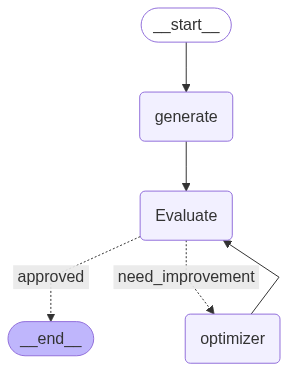

In [89]:
workflow

In [91]:
init_state = {
    "topic": "How to switch job in machine learning for 6 7 months of experience ",
    "tweet": "",
    "evaluation": "",
    "optimized_tweet": "",
    "itreation": 1,
    "max_iterations": 5,
    "feedback": ""  # If you use feedback in your state, add this too
}

result = workflow.invoke(init_state)



Evaluation value: approved


KeyError: '__end__'